Projet 3
========

TP3 séance 2-3
========
--------
Ricardo

Safwane

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import time
import scipy
import huffman
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc # pip install Pillow
import matplotlib.pylab as pylab

%matplotlib inline 
scipy.__version__

'1.1.0'

 1) Pour réduire significativement la taille de l’image, quelles sont à votre avis les informations d’une image qui pourraient être éliminées sans trop dégrader le contenu de l’image.

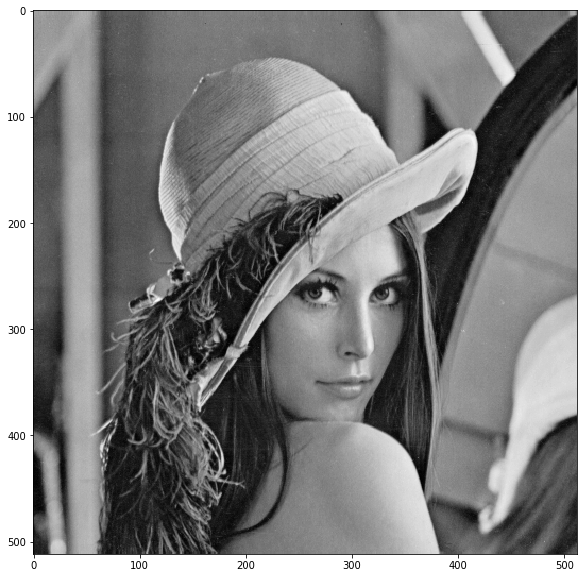

In [2]:
im = (cv2.imread('lena.png',0))
plt.figure(figsize = (20,10))
plt.imshow(im, cmap = 'gray')
plt.show()



Pour réduire la taille d'une image on peut éliminer les détails de l'image. Ces détails correspondent aux hautes fréquences. Il nous faut donc un outil qui nous permettra de réduire les hautes fréquences.

2) Quelle outil mathématique permettrait d’accéder au contenu que vous avez identifié
à la question précédente ? Programmer l’outil mathématique identifié et étudier ses
propriétés de base.

Pour accéder et réduire les hautes fréquences, nous allons utiliser la DCT (Discrete Cosine Transform). La DCT nous permettra de passer à l'étape de quantification puis de codage.

In [3]:
# Programmation de la DCT

# On applique la DCT 1D qui est présente dans 
# scipy.fftpack sur les 2 axes
# pour avoir une DCT 2D
def DCT2(image):
    dctImgILigne = scipy.fftpack.dct(image, axis=0, norm  = 'ortho')
    dctImgI = scipy.fftpack.dct(dctImgILigne, axis=1, norm  = 'ortho')
    return dctImgI


# Programmation de la DCT inverse

# On applique la DCT inverse 1D qui est présente 
# dans scipy.fftpack sur 
# les 2 axes pour avoir une DCT inverse 2D
def iDCT2(dct):
    imgLigne = scipy.fftpack.idct(dct, axis=0, norm  = 'ortho')
    img = scipy.fftpack.idct(imgLigne, axis=1, norm  = 'ortho')
    return img

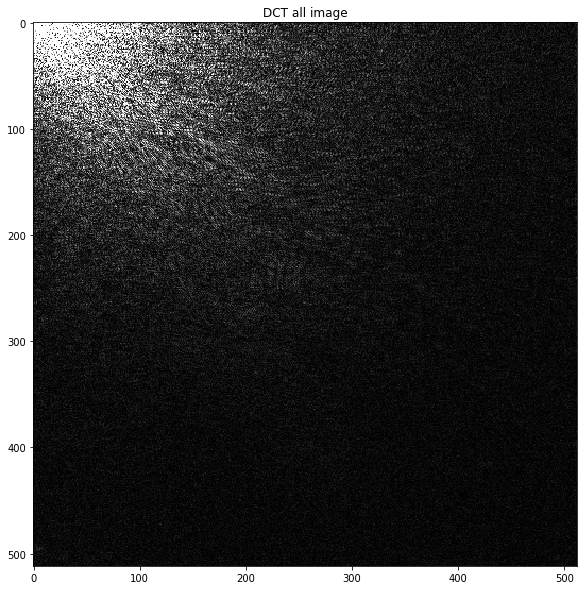

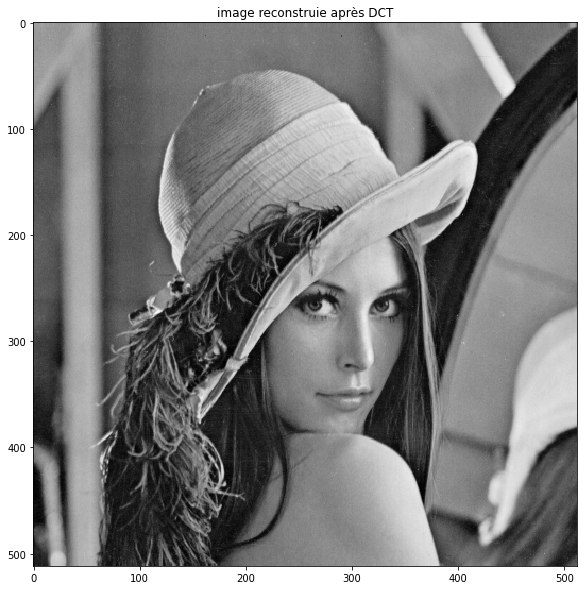

In [4]:
dct_im = DCT2(im)

plt.figure(figsize = (100,10))
plt.imshow(np.absolute(dct_im),cmap='gray',vmax= np.max(dct_im)*0.001,vmin = 0)
plt.title( "DCT all image")
plt.show()
#print np.absolute(dct_im)

image = iDCT2(dct_im)
plt.figure(figsize = (20,10))
plt.imshow(image, cmap = 'gray')
plt.title( "image reconstruie après DCT")
plt.show()

D'après le cours, la DCT va nous permettre de travailler directement sur l'intensité des pixels. De plus la DCT permet de compacter l'énergie et ainsi d'avoir des indormations contenues dans moins de coefficients. Dernier point important, on utilise la DCT plutôt que la FFT car la DCT produit seulement des réels, cela est donc plus rapide à calculer que la FFT.

3)Est-il préférable de travailler avec des blocs de pixels (de taille 8x8 par exemple) ou
bien sur une image entière ? Appliquer l’outil mathématique identifié à la question précédente sur des blocs de pixels 8x8.

Si on travaille sur des blocs 8x8, le calcul de la DCT sera plus rapide et donc plus efficace. En effet au lieu de faire 512x512 fois le calcul de la DCT, on fera 8x8 fois le calcul de la DCT sur les 512/8 blocs. Donc on passe de 262144 (512x512) à 4096 (8x8x512/8) calculs de DCT. Cependant on perd de l'information il y a un donc compromis à avoir entre rapidité du calcul et qualité de l'image.


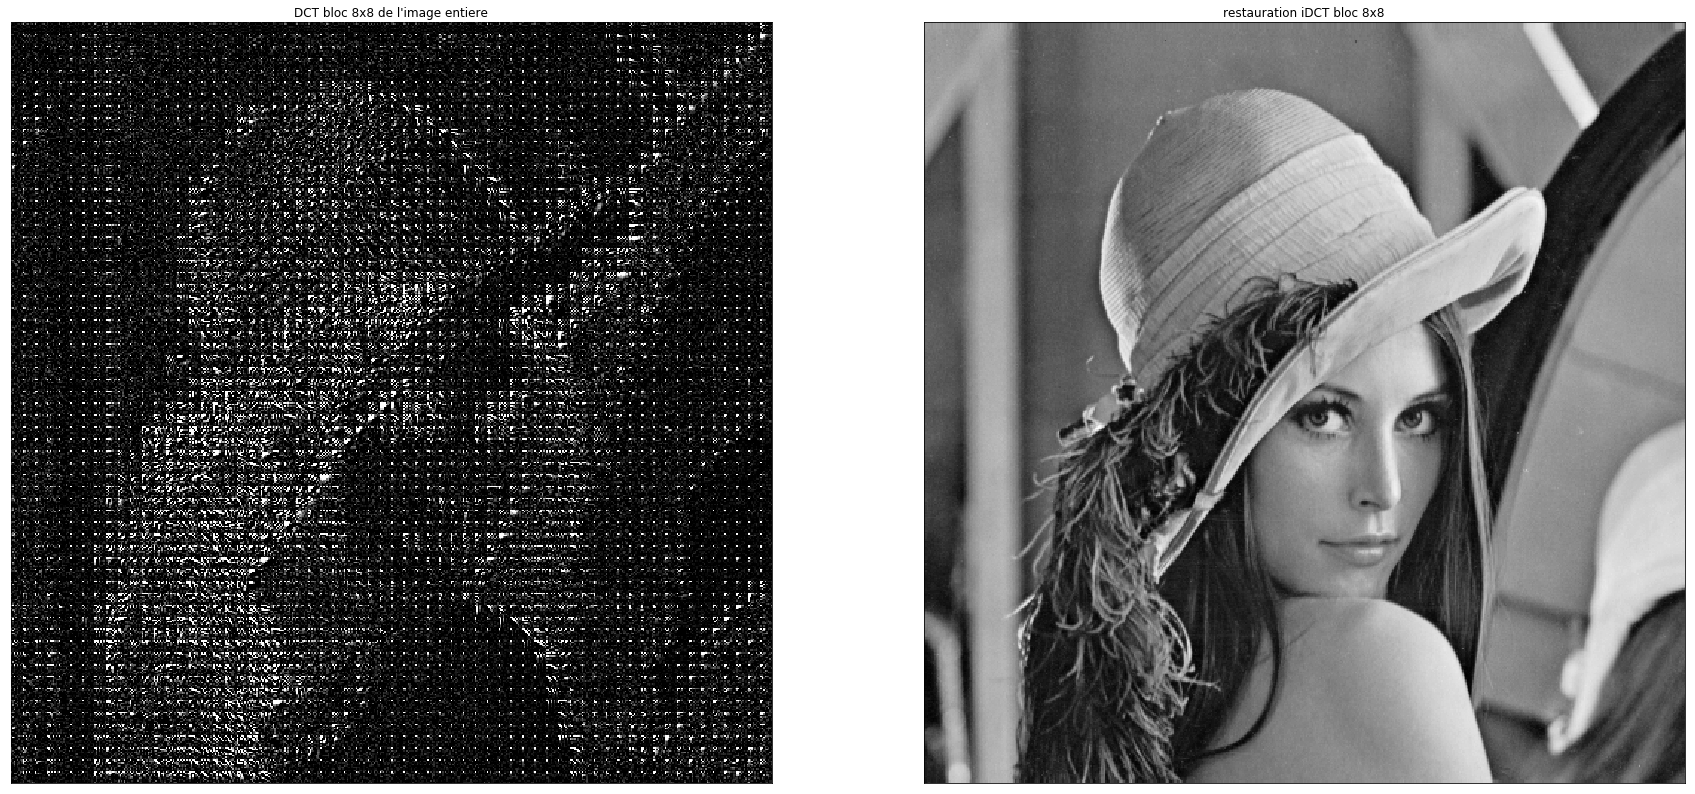

In [5]:
def DCTBloc8x8Image(img):
    (nbColonne, nbLigne) = img.shape
    matriceBloc = np.zeros((nbColonne, nbLigne)) # contiendra la DCT bloc 8x8

    # Selection des sous-matrices de 8x8 dans la matrice de 512x512
    for x in range(0, nbLigne,8):
        for y in range(0, nbColonne,8):
            matriceBloc[x:x+8,y:y+8] = DCT2(img[x:x+8,y:y+8]) # DCT sur sous-matrices de 8x8 de l'image
    
    return matriceBloc


def iDCTBloc8x8Image(dct):
    (nbColonne, nbLigne) = dct.shape
    matriceBloc = np.zeros((nbColonne, nbLigne)) # contiendra l'image reconstituee

    # Selection des sous-matrices de 8x8 dans la matrice de 512x512
    for x in range(0, nbLigne,8):
        for y in range(0, nbColonne,8):
            matriceBloc[x:x+8,y:y+8] = iDCT2(dct[x:x+8,y:y+8]) # DCT inverse sur sous-matrices de 8x8
    
    return matriceBloc


#DCT par bloc de 8x8 appliquee a toute l'image
dctBlocImg = DCTBloc8x8Image(im) # DCT sur bloc de 8x8 de l'image
imgBlocRe = iDCTBloc8x8Image(dctBlocImg) # DCT inverse sur bloc de 8x8 de la DCT bloc 8x8

plt.figure(0,figsize = (30,40))
plt.subplot(121),plt.imshow(dctBlocImg, cmap = 'gray', vmax = np.max(dctBlocImg)*0.01, vmin = 0)
plt.title("DCT bloc 8x8 de l'image entiere"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(imgBlocRe, cmap = 'gray')
plt.title("restauration iDCT bloc 8x8"), plt.xticks([]), plt.yticks([])
plt.show()


4)Proposer une méthode efficace pour réduire l'information à conserver. Cette méthode
doit dépendre d'au moins un paramètre de réglage qui permet de maîtriser le niveau de
compression souhaité. Programmer la méthode proposée.


In [6]:
# Dans cette question nous allons implémenter un algorithme de quantification puis de compression vu en cours.

# Définition de la matrice de quantification
def Matrice_quantification(q):
    m = np.zeros((8,8))
    for i in range (8):
        for j in range (8):
            m[i][j] = 1+(1+i+j)*q
    return m

# exemple pour q = 2
qualite = 2
MatriceQuantification=Matrice_quantification(qualite)

print(MatriceQuantification)

[[ 3.  5.  7.  9. 11. 13. 15. 17.]
 [ 5.  7.  9. 11. 13. 15. 17. 19.]
 [ 7.  9. 11. 13. 15. 17. 19. 21.]
 [ 9. 11. 13. 15. 17. 19. 21. 23.]
 [11. 13. 15. 17. 19. 21. 23. 25.]
 [13. 15. 17. 19. 21. 23. 25. 27.]
 [15. 17. 19. 21. 23. 25. 27. 29.]
 [17. 19. 21. 23. 25. 27. 29. 31.]]


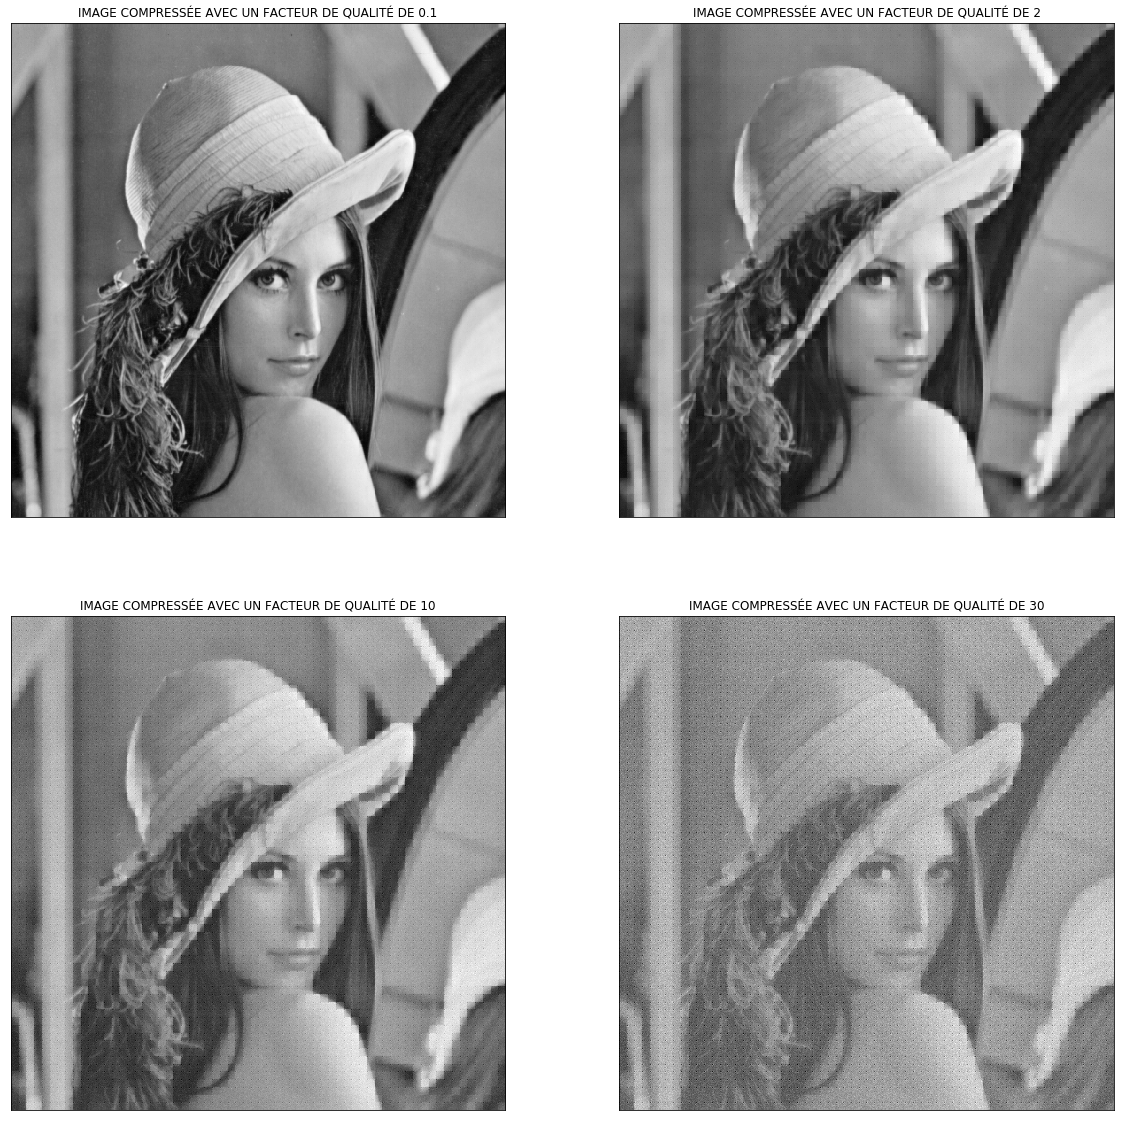

In [7]:
# Définition de la fonction de compression
def compression(img,q): # q = facteur de qualité
    (nbColonne, nbLigne) = img.shape
    img_compressee = np.zeros((nbColonne, nbLigne))
    mq = Matrice_quantification(q)
    for x in range(0, nbLigne,8):
        for y in range(0, nbColonne,8):
            img_compressee[x:x+8,y:y+8] = iDCT2(DCT2(img[x:x+8,y:y+8])//mq)
    return img_compressee

plt.figure(0,figsize = (20,20))
# On affiche différentes images compressées pour des valeurs du facteur de qualité différentes
for q in [(0.1,221),(2,222),(10,223),(30,224)]:
    plt.subplot(q[1])
    plt.imshow(compression(im,q[0]), cmap = 'gray')
    plt.title('IMAGE COMPRESSÉE AVEC UN FACTEUR DE QUALITÉ DE ' + str(q[0])), plt.xticks([]), plt.yticks([])
plt.show()


On voit que plus le facteur de qualité est élevé, plus l'image devient moins nette. On voit nottament apparaître des petits carrés. On s'attend à pouvoir diminuer la taille mémoire qu'occupe l'image. On va donc passer au codage de la nouvelle image.

5) Dans la sèance 1, vous avez étudié des outils pour la compression sans perte. Dans les questions précédente , vous avez proposé une méthode de compression avec perte. Comment
pourrait-on conjuguer ces deux approches pour obtenir une forte compression. Programmer la méthode proposée.

Nous allons utilisé l'algorithme d'Huffman pour compresser l'image sans perte. Comme nous avons déjà compressé l'image (avec perte) nous allons appliquer l'algorithme d'Huffman non pas sur l'image originale mais sur l'image qui a déjà été compressé avec perte. On combine ainsi les 2 méthodes de compression, une avec perte et l'autre sans perte.

In [8]:
# La fonction suivante correspond à l'implémentation de l'algorithme d'Huffman sur une image.
# Elle renvoie la longueur moyenne d'un pixel après codage d'Huffman ainsi que l'entropie
def codage_huffman(img):
    (nbColonne, nbLigne) = img.shape
    longueur_bloc, longueur_totale, entropie = 0, 0, 0 # initialisation
    for x in range(0, nbLigne,8):
        for y in range(0, nbColonne,8):
            dctBloc = DCT2(img[x:x+8,y:y+8])
            val, count, enc = huffman.huffman_compute(dctBloc)
            for i in range(len(val)):
                longueur = len(enc[val[i]])*count[i] # longueur d'un pixel * fréquence d'apparition
                longueur_bloc += longueur
                # début du calcul de l'entropie
                prob = count[i]/dctBloc.size
                entropie = entropie + prob*np.log2(prob)
                # fin du calcul de l'entropie
            longueur_totale += longueur_bloc/dctBloc.size # longueur moyenne d'un bloc
            longueur_bloc = 0
    return longueur_totale/(img.size/dctBloc.size), -entropie/(img.size/dctBloc.size), longueur_totale

longueur_moyenne, entropie, longueur_totale = codage_huffman(im)
print("longueur moyenne d'un pixel de l'image originale = ", longueur_moyenne)
print("Entropie = ", entropie)
print("longueur_totale = ", longueur_totale, "\n")

for q in [0.1,2,10,30]:
    longueur_moyenne, entropie, longueur_totale = codage_huffman(compression(im,q))
    print("longueur moyenne d'un pixel de l'image compréssée avec un facteur de qualité de", q, "=", longueur_moyenne)
    print("Entropie = ", entropie)
    print("longueur_totale = ", longueur_totale, "\n")

longueur moyenne d'un pixel de l'image originale =  3.6322288513183594
Entropie =  3.596112397532332
longueur_totale =  14877.609375 

longueur moyenne d'un pixel de l'image compréssée avec un facteur de qualité de 0.1 = 2.983184814453125
Entropie =  2.943375137454104
longueur_totale =  12219.125 

longueur moyenne d'un pixel de l'image compréssée avec un facteur de qualité de 2 = 1.55426025390625
Entropie =  1.3612819616042866
longueur_totale =  6366.25 

longueur moyenne d'un pixel de l'image compréssée avec un facteur de qualité de 10 = 1.3552703857421875
Entropie =  1.0693738534720176
longueur_totale =  5551.1875 

longueur moyenne d'un pixel de l'image compréssée avec un facteur de qualité de 30 = 1.3472137451171875
Entropie =  1.03001490137017
longueur_totale =  5518.1875 



On voit que plus le facteur de qualité est élevé, plus la longueur moyenne d'un pixel diminue ainsi que la longueur totale des pixels donc on diminue bien l'espace mémoire occupée par l'image. De plus on peut comparer ces longueurs moyennes à l'entropie : on voit alors que l'on peut encore gagner de la place surtout quand q est élevé.

In [54]:
def codage_huffman_reduit(img):
    (nbColonne, nbLigne) = img.shape
    laliste = []
    longueur, longueur_totale = 0, 0 # initialisation
    for x in range(0, nbLigne,256):
        for y in range(0, nbColonne,256):
            dctBloc = DCT2(img[x:x+256,y:y+256])
            val, count, enc = huffman.huffman_compute(dctBloc)
            for i in range(len(val)):
                longueur += len(enc[val[i]])*count[i] # longueur d'un pixel * fréquence d'apparition
            longueur_totale += longueur/dctBloc.size # longueur moyenne d'un bloc
            longueur = 0
    return longueur_totale/(img.size/dctBloc.size)


6) Étudier l'efficacité de cette méthode en terme de compression et en terme de respect de
la qualité visuelle.

Pour étudier l'efficacité de cette méthode nous allons tracer 3 graphiques :  
1) La taille mémoire de l'image en fonction du facteur de qualité  
2) Le taux de compression en fonction du facteur de qualité  
3) L'erreur quadratique moyenne en fonction de la taille entre l'image originale et l'image compressée

In [55]:
# Ici on calcule 

qualite = []
taille = []
taux = []
EQM = []

from sklearn.metrics import mean_squared_error

q=0.1
ll = []
ll2 =[]
ll3 = []
tps = time.time()
for i in range(40):
    a = time.time()
    imageCompressee=compression(im,q)
    b = time.time()
    ll.append(b-a)
    qualite.append(q)
    taille_q = codage_huffman_reduit(compression(im,q))
    c = time.time()
    ll2.append(c-b)
    taille.append(taille_q)
    taux.append(taille_q/(im.size*8))
    error = mean_squared_error(imageCompressee,im)/(im.size)
    EQM.append(error)
    q=q+0.5
    d = time.time()
    ll3.append(d-a)
print(time.time()-tps)
print(min(ll),max(ll))
print(min(ll2),max(ll2))
print(min(ll3),max(ll3))


9.52256441116333
0.10769844055175781 0.15294837951660156
0.11735010147094727 0.18972110748291016
0.2260582447052002 0.3437776565551758


In [ ]:
# Taille en fonction du facteur de qualité
plt.plot(np.array(qualite),np.array(taille))
plt.title('Taille en fonction du facteur de qualité')
plt.show()
# 21 sec
# 19.563227653503418
# 0.10759329795837402 0.1494584083557129
# 0.3445112705230713 0.6371755599975586
# 0.4534308910369873 0.7879116535186768


Nous pouvons voir que si on augmente le facteur de qualité la taille de l'image va diminuer parce que on aura perdu plus d'information et on va avoir besoin de moins des codes binaire pour le répresenter.

In [ ]:
# Taux de compression en fonction du facteur de qualité
plt.plot(np.array(qualite),np.array(taux))
plt.title('Taux de compression en fonction du facteur de qualité')
plt.show()

Le taux de compression est par définition le volumen final entre le volumen initial de l'image. On voir voir dans le graphique ci-dessous que le rapport diminue quand on va diminuer la qualité parce que le volumen final diminue quand on perd de l'information et on utilise des codes plus courts.

In [ ]:
# Erreur Quadratique en fonction de la taille
plt.plot(np.array(taille),np.array(EQM))
plt.title('Erreur Quadratique en fonction de la taille')
plt.show()

On peut remarquer que l'erreur va diminuer de plus en plus quand on augmente la taille. Cela est dû au faite qu'on utilise plus de mémoire pour pouvoir garder le plus possible l'image original.